In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np 
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

data = pd.read_csv("../../data/data_export.csv")

data["cited_by_count"] = pd.to_numeric(data["cited_by_count"], errors="coerce")
data = data.dropna(subset=["cited_by_count", "author_h_index", "journal_h_index", "institution_h_index"])

In [60]:
data = data[data['publication_year']<2024]

In [5]:
data['log_cited_by_count'] = np.log1p(data['cited_by_count'])

features = ['author_h_index', 'journal_h_index', 'institution_h_index']

importance_data = []

categories = data['predicted_category'].unique()

for category in categories:
    subset = data[data['predicted_category'] == category]

    X = subset[features]
    y = subset['log_cited_by_count']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)

    perm_importance = permutation_importance(rf, X_test, y_test, random_state=42, n_repeats=100)
    importance_values = perm_importance.importances_mean
    importance_data.append({
        'Category': category,
        'Author Importance': importance_values[0],
        'Journal Importance': importance_values[1],
        'Institution Importance': importance_values[2]
    })

importance_df = pd.DataFrame(importance_data)

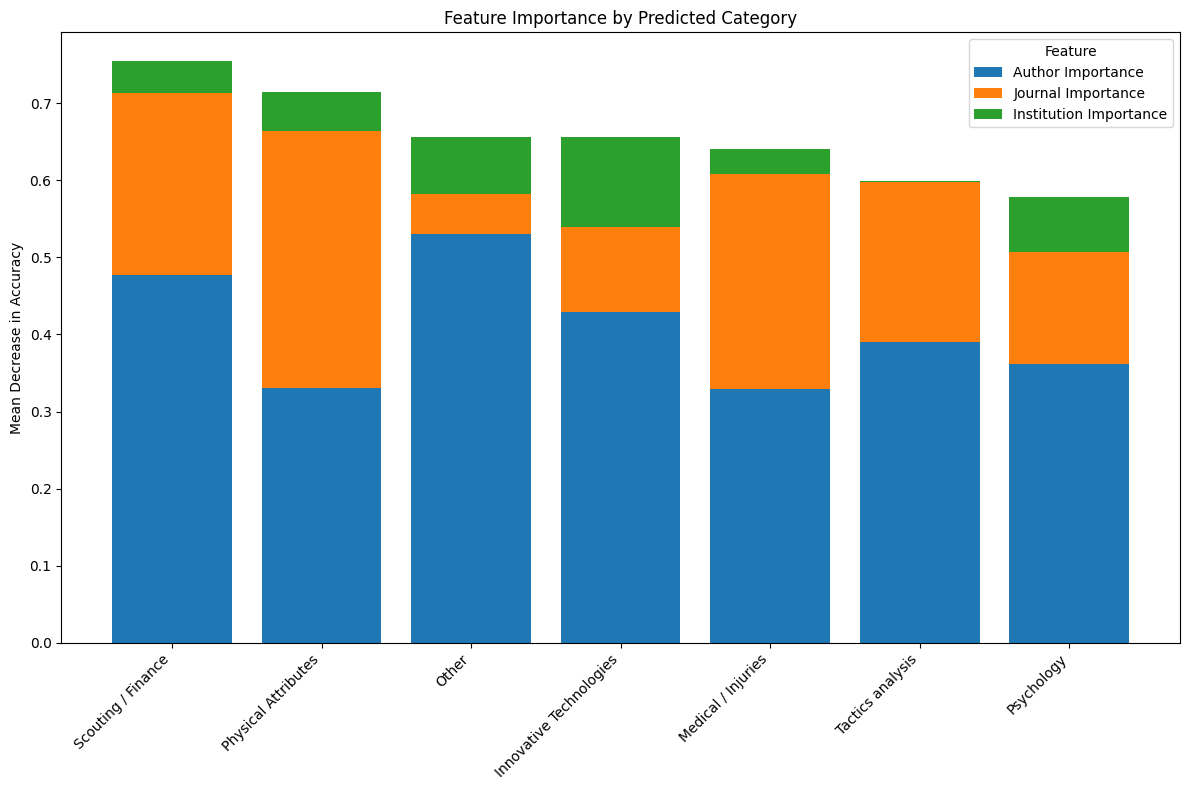

In [6]:
importance_df['Total Importance'] = (
    importance_df['Author Importance'] +
    importance_df['Journal Importance'] +
    importance_df['Institution Importance']
)

importance_df = importance_df.sort_values(by='Total Importance', ascending=False)

categories = importance_df['Category']
author_importance = importance_df['Author Importance']
journal_importance = importance_df['Journal Importance']
institution_importance = importance_df['Institution Importance']

plt.figure(figsize=(12, 8))
bar_width = 0.8
plt.bar(categories, author_importance, label='Author Importance', width=bar_width)
plt.bar(categories, journal_importance, bottom=author_importance, label='Journal Importance', width=bar_width)
plt.bar(categories, institution_importance, 
        bottom=author_importance + journal_importance, label='Institution Importance', width=bar_width)


plt.ylabel('Mean Decrease in Accuracy')
plt.title('Feature Importance by Predicted Category')
plt.legend(title='Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [64]:
from sklearn.utils import shuffle
import numpy as np

def permutation_test(model, X_test, y_test, feature, n_permutations=100):
    baseline_score = model.score(X_test, y_test)  # Baseline accuracy/R²
    perm_scores = []

    for _ in range(n_permutations):
        X_test_permuted = X_test.copy()
        X_test_permuted[feature] = shuffle(X_test_permuted[feature])
        perm_scores.append(model.score(X_test_permuted, y_test))

    perm_scores = np.array(perm_scores)
    p_value = np.mean(perm_scores >= baseline_score)

    return baseline_score, perm_scores, p_value

feature = 'author_h_index'
baseline_score, perm_scores, p_value = permutation_test(rf, X_test, y_test, feature)
print(f"Baseline Score: {baseline_score:.4f}")
print(f"Mean Permuted Score: {np.mean(perm_scores):.4f}")
print(f"P-value: {p_value:.4f}")


Baseline Score: 0.2239
Mean Permuted Score: 0.2239
P-value: 1.0000
